**Research Question 1 (Regression):** Can we accurately predict a driver's fastest lap time using only *pre-race* data?
- **Methods:** Ridge Regression and LASSO (to handle multicollinearity).
- **Goal:** Identify the most critical pre-race factors (e.g., qualifying performance, grid position) while avoiding "data leakage" (using post-race data like average lap time).

Import and Loading of the Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, RocCurveDisplay, confusion_matrix

filepath = glob.glob('f1datasets/*.csv') # 14 datasets
f1_dfs = {}
for file in filepath:
    filename = os.path.basename(file)
    df_name = os.path.splitext(filename)[0]
    f1_dfs[df_name] = pd.read_csv(file)
print("Datasets loaded.")

rand_st = 7604 # random state for reproducibility

cv5 = KFold(n_splits=5, shuffle=True, random_state=rand_st) # 5-fold cross-validation

Datasets loaded.


**Cleaning the data // Feature Engineering**

In [3]:
for df_name in f1_dfs:
    f1_dfs[df_name].replace(r'\\N', np.nan, inplace=True)
print("Missing values replaced.")

def time_to_ms(time_str): # converts time strings to milliseconds
    if pd.isna(time_str): 
        return np.nan
    parts = str(time_str).split(':')
    try: 
        if len(parts) == 2: # M:SS.mmm
            return int((int(parts[0]) * 60 + float(parts[1])) * 1000)
        elif len(parts) == 3: # H:MM:SS.mmm
            return int((int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])) * 1000)
        else: return np.nan
    except ValueError: 
        return np.nan

# Clean 'results' (Response Variables)
df_results = f1_dfs['results'].copy()
df_results['fastestLapTime_ms'] = df_results['fastestLapTime'].apply(time_to_ms)
df_results['positionOrder'] = pd.to_numeric(df_results['positionOrder'], errors='coerce')
df_results['grid'] = pd.to_numeric(df_results['grid'], errors='coerce')

# Clean 'qualifying' (Predictors)
df_quali = f1_dfs['qualifying'].copy()
for col in ['q1', 'q2', 'q3']:
    df_quali[f'{col}_ms'] = df_quali[col].apply(time_to_ms)
df_quali_short = df_quali[['raceId', 'driverId', 'constructorId', 'position', 'q1_ms', 'q2_ms', 'q3_ms']].rename(columns={'position': 'qualifying_position'})

# Clean 'races' & 'drivers' (Context)
df_races = f1_dfs['races'].copy()
df_races['date'] = pd.to_datetime(df_races['date'])
df_races_short = df_races[['raceId', 'year', 'round', 'circuitId', 'date']]

df_drivers = f1_dfs['drivers'].copy()
df_drivers['dob'] = pd.to_datetime(df_drivers['dob'])
df_drivers_short = df_drivers[['driverId', 'driverRef', 'nationality', 'dob']]

# Merge into Master DataFrame
master_f1 = pd.merge(df_results, df_races_short, on='raceId', how='left')
master_f1 = pd.merge(master_f1, df_quali_short, on=['raceId', 'driverId', 'constructorId'], how='left')
master_f1 = pd.merge(master_f1, df_drivers_short, on='driverId', how='left')

# Feature Engineering
master_f1['driver_age_at_race'] = (master_f1['date'] - master_f1['dob']).dt.days / 365.25 # age in years

print("Master DataFrame created.")
master_f1.head()

Missing values replaced.
Master DataFrame created.


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,circuitId,date,qualifying_position,q1_ms,q2_ms,q3_ms,driverRef,nationality,dob,driver_age_at_race
0,1,18,1,1,22,1,1,1,1,10.0,...,1,2008-03-16,1.0,86572.0,85187.0,86714.0,hamilton,British,1985-01-07,23.186858
1,2,18,2,2,3,5,2,2,2,8.0,...,1,2008-03-16,5.0,85960.0,85518.0,87236.0,heidfeld,German,1977-05-10,30.850103
2,3,18,3,3,7,7,3,3,3,6.0,...,1,2008-03-16,7.0,86295.0,86059.0,88687.0,rosberg,German,1985-06-27,22.718686
3,4,18,4,4,5,11,4,4,4,5.0,...,1,2008-03-16,12.0,86907.0,86188.0,NaN,alonso,Spanish,1981-07-29,26.631075
4,5,18,5,1,23,3,5,5,5,4.0,...,1,2008-03-16,3.0,85664.0,85452.0,87079.0,kovalainen,Finnish,1981-10-19,26.406571


**Prepping and Splitting**

In [4]:
X_cols = ['year', 'circuitId', 'grid', 'qualifying_position', 'q1_ms', 'q2_ms', 'q3_ms', 'driver_age_at_race']
X = master_f1[X_cols].copy()
y1 = master_f1['fastestLapTime_ms']

# Drop rows with missing target values
# Cannot train a supervised model without target values
mask = y1.notna()
X = X[mask]
y1 = y1[mask]

# Impute missing values in predictors
# Mean imputation would be skewed by outliers, so we use median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-Test Split: 80-20
X_train, X_test, y1_train, y1_test = train_test_split(X_imputed, y1, test_size=0.2, random_state=rand_st)

# Scaling
# Distance-based models (i.e. Ridge, LASSO, PCA, PLS) require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data preprocessing complete.")

Data preprocessing complete.


**Model Building**

In [5]:
# RidgeCV
alphas = np.logspace(-1, 2, 100) # 0.1 to 100
ridge_model = RidgeCV(alphas=alphas, cv=cv5).fit(X_train_scaled, y1_train)
print("RidgeCV model trained.")
print(f"Ridge Alpha: {ridge_model.alpha_}")

# LassoCV
lasso_model = LassoCV(cv=cv5, random_state=rand_st).fit(X_train_scaled, y1_train) # LassoCV finds the optimal alpha automatically
print("\nLassoCV model trained.")
print(f"Lasso Alpha: {lasso_model.alpha_}")

# Evaluation using R^2 score
r2_ridge = r2_score(y1_test, ridge_model.predict(X_test_scaled))
r2_lasso = r2_score(y1_test, lasso_model.predict(X_test_scaled))
print(f"\nRidge R^2 on Test Set: {r2_ridge:.4f}")
print(f"Lasso R^2 on Test Set: {r2_lasso:.4f}")

# Feature Importance
coefs = pd.DataFrame({
    'Feature': X_cols,
    'Coef': lasso_model.coef_,
    'AbsCoef': np.abs(lasso_model.coef_)
}).sort_values(by='AbsCoef', ascending=False)

print("\nLASSO Feature Importances:")
print(coefs[['Feature', 'Coef']])

RidgeCV model trained.
Ridge Alpha: 3.511191734215131

LassoCV model trained.
Lasso Alpha: 28.47933340957135

Ridge R^2 on Test Set: 0.7363
Lasso R^2 on Test Set: 0.7361

LASSO Feature Importances:
               Feature         Coef
4                q1_ms  9995.170689
5                q2_ms   592.223015
1            circuitId   420.529839
0                 year   392.834470
2                 grid   367.828656
6                q3_ms   343.455228
7   driver_age_at_race     5.937320
3  qualifying_position     0.000000


**Visualizing Q1 Modeling**

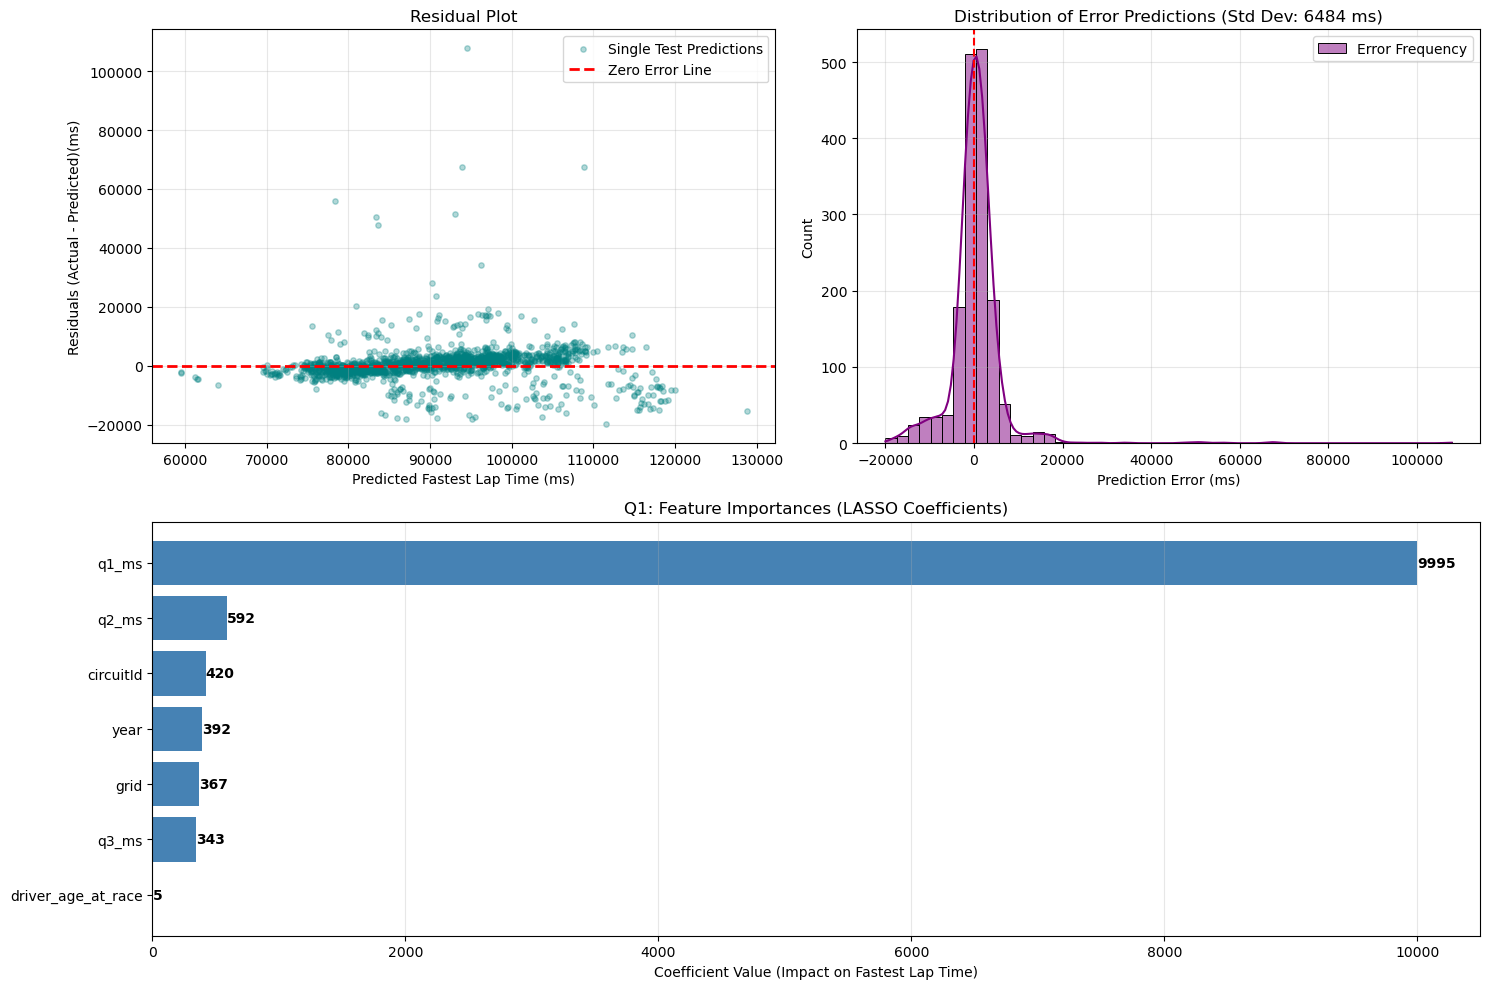

In [ ]:
y1_pred = lasso_model.predict(X_test_scaled)
residuals = y1_test - y1_pred

plt.figure(figsize=(15, 10))

# Setting up subplots
# Residual Plot
plt.subplot(2, 2, 1)
plt.scatter(y1_pred, residuals, alpha=0.3, color='teal', s=15, label='Single Test Predictions')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.xlabel('Predicted Fastest Lap Time (ms)')
plt.ylabel('Residuals (Actual - Predicted)(ms)')
plt.title('Residual Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Error Distribution
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=50, label='Error Frequency')
plt.xlabel('Prediction Error (ms)')
plt.title(f'Distribution of Error (Std Dev: {np.std(residuals):.0f} ms)')
plt.axvline(x=0, color='red', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)

# LASSO Coefficients (Feature Importance)
nonzero_coefs = coefs[coefs['AbsCoef'] > 0].sort_values(by='AbsCoef', ascending=True)
plt.subplot(2, 1, 2)
bars = plt.barh(nonzero_coefs['Feature'], nonzero_coefs['Coef'], color='steelblue', label='LASSO Coefficient')
for bar in bars:
    width = bar.get_width()
    plt.text(
        width, 
        bar.get_y() + bar.get_height() / 2,
        f'{int(width)}',
        va='center',
        ha='left',
        fontsize=10,
        color='black',
        fontweight='bold'
    )
plt.title("Q1: Feature Importances (LASSO Coefficients)")
plt.xlabel('Coefficient Value (Impact on Fastest Lap Time)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Question 2 Models**

In [8]:
# Aligning target variable (y2) for train-test split
y2 = master_f1['positionOrder'][mask]
_, _, y2_train, y2_test = train_test_split(X_imputed, y2, test_size=0.2, random_state=rand_st)

# PCR
pcr_scores = []
for k in range(1, X_train_scaled.shape[1] + 1):
    pca = PCA(n_components=k)
    X_reduced = pca.fit_transform(X_train_scaled)
    lr = LinearRegression()
    score = np.mean(cross_val_score(lr, X_reduced, y2_train, cv=cv5, scoring='neg_mean_squared_error')) # minimize MSE
    pcr_scores.append(score)
best_k_pcr = np.argmax(pcr_scores) + 1
print(f"Optimal PCR components: {best_k_pcr}")

# PLS Tuning
pls_scores = []
for k in range(1, X_train_scaled.shape[1] + 1):
    pls = PLSRegression(n_components=k)
    score = np.mean(cross_val_score(pls, X_train_scaled, y2_train, cv=cv5, scoring='neg_mean_squared_error')) # minimize MSE
    pls_scores.append(score)
best_k_pls = np.argmax(pls_scores) + 1
print(f"Optimal PLS components: {best_k_pls}")

Optimal PCR components: 8
Optimal PLS components: 6


**Plotting PCR vs PLS**

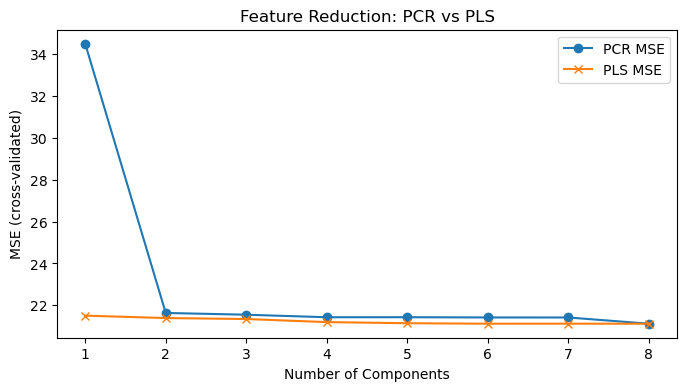

In [15]:
plt.figure(figsize=(8,4))
plt.plot(range(1, X_train_scaled.shape[1] + 1), -np.array(pcr_scores), marker='o', label='PCR MSE')
plt.plot(range(1, X_train_scaled.shape[1] + 1), -np.array(pls_scores), marker='x', label='PLS MSE')
plt.xlabel('Number of Components')
plt.ylabel('MSE (cross-validated)')
plt.legend()
plt.title('Feature Reduction: PCR vs PLS')
plt.show()